In [2]:
import sys

In [3]:
sys.path.insert(0,'../')
import pyathena as pa

'/home/changgoo/pyathena_master/notebook/../pyathena/__init__.py'

In [4]:
from pyathena.tigress_ncr.load_sim_tigress_ncr import LoadSimTIGRESSNCR

In [5]:
s = LoadSimTIGRESSNCR("/tigress/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.xy2048.eps0.0",verbose=True)

[LoadSimTIGRESSNCR-INFO] savdir : /tigress/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.xy2048.eps0.0


[LoadSimTIGRESSNCR-INFO] basedir: /tigress/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.xy2048.eps0.0
[LoadSimTIGRESSNCR-INFO] athinput: /tigress/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.xy2048.eps0.0/out.txt
[LoadSimTIGRESSNCR-INFO] athena simulation
[LoadSimTIGRESSNCR-INFO] problem_id: R8_8pc_NCR
[LoadSimTIGRESSNCR-INFO] timeit: /tigress/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.xy2048.eps0.0/timeit.txt
[LoadSimTIGRESSNCR-INFO] hst: /tigress/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.xy2048.eps0.0/hst/R8_8pc_NCR.hst
[LoadSimTIGRESSNCR-INFO] vtk in tar: /tigress/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.xy2048.eps0.0/vtk nums: 200-668
[LoadSimTIGRESSNCR-INFO] starpar_vtk: /tigress/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.xy2048.eps0.0/starpar nums: 200-668
[LoadSimTIGRESSNCR-INFO] zprof: /tigress/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.xy2048.eps0.0/zprof nums: 200-668
[LoadSimTIGRESSNCR-WARNING] rst files not found in /tigress/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.xy2048.eps0.0.


# Background

In a shearing-box, the background velocity is 
$$ v_{y,shear} = -q\Omega x $$
where the shear parameter $q\equiv -d\ln\Omega/d\ln R|_{R=R_{0}} = 1$ in our simulations. 

The shearing-periodic boundary conditions in $x$ at time $t$ then satisfy, e.g. for density,
$$ \rho(x\pm L_x,y,z) = \rho(x, \mod(y \mp q\Omega L_x t, L_y), z )$$
and all other quantities except $v_y$.

For $y$-velocity, the bacgkround velocity has to be added such that
$$ v_y(x\pm L_x,y,z) = v_y(x, \mod(y \mp q\Omega L_x t, L_y), z) \mp q\Omega L_x$$

Below I will assume that you read in the data array using `pyathena` and `xarray`. Then, I will build data in the expanded domain utilizing those. This should work for full 3D array or 2D slices through any arbitrary $z$. 

# Demonstration of the procedure

In [ ]:
ds = s.load_vtk(290)

In [25]:
time = ds.domain["time"]
Lx,Ly,Lz = ds.domain["Lx"]
dx,dy,dz = ds.domain["dx"]
qOmL = s.par["problem"]["qshear"]*s.par["problem"]["Omega"]*Lx

In [26]:
data = ds.get_field(["nH","T","vy"])

In [40]:
import xarray as xr
# exapnd in x assuming periodic BC
data_left = data.copy(deep=True).assign_coords(x=data.coords["x"]-Lx)
data_right = data.copy(deep=True).assign_coords(x=data.coords["x"]+Lx)
data_xexp = xr.concat([data_left,data,data_right],dim="x")

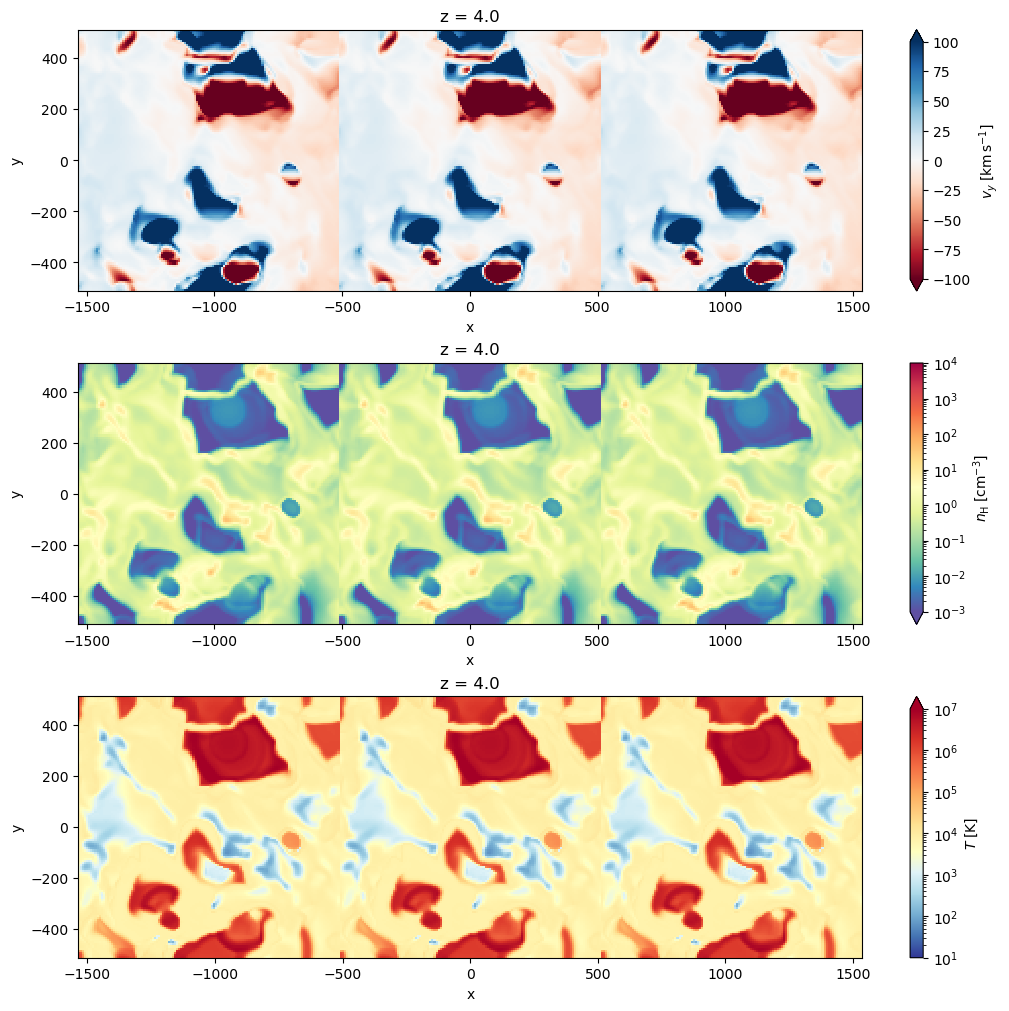

In [55]:
fig, axes = plt.subplots(3,1, figsize=(10,10), constrained_layout=True)
for f, ax in zip(data_xexp, axes):
    data_xexp[f].sel(z=0,method="nearest").plot(ax=ax,**s.dfi[f]["imshow_args"])
plt.gca().set_aspect("equal")

In [97]:
# exapnd in x assuming shear-periodic BC
from scipy.ndimage import shift
qOmLt = qOmL * time

data_left = data.copy(deep=True).assign_coords(x=data.coords["x"]-Lx)
data_right = data.copy(deep=True).assign_coords(x=data.coords["x"]+Lx)
for var in data:
    shifted_L = shift(data_left[var].data, (0., qOmLt / dy, 0.), mode="grid-wrap", order=1)
    shifted_R = shift(data_right[var].data, (0., -qOmLt / dy, 0.), mode="grid-wrap", order=1)
    if var == "vy":
        shifted_L += qOmL
        shifted_R -= qOmL
    data_left[var] = (("z","y","x"), shifted_L)
    data_right[var] = (("z","y","x"), shifted_R)
data_xexp_sh = xr.concat([data_left,data,data_right],dim="x")

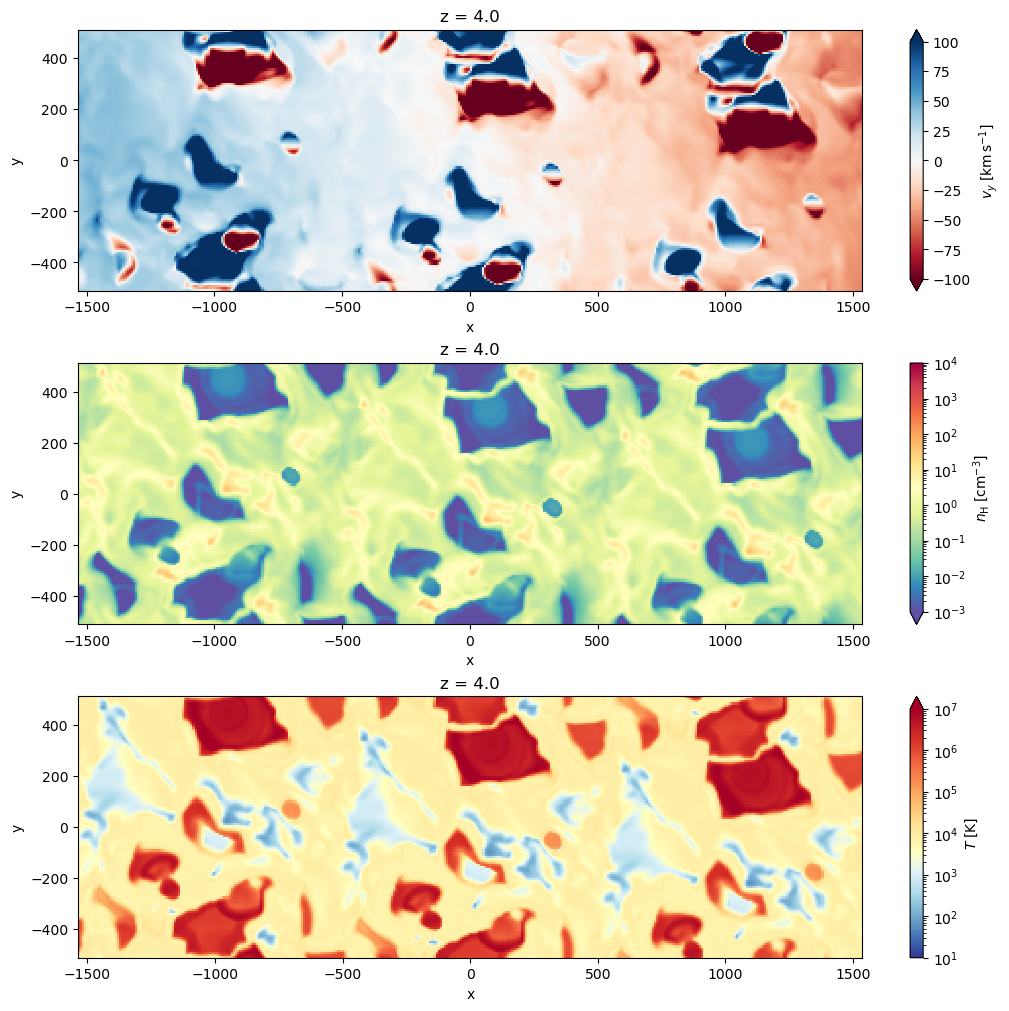

In [90]:
fig, axes = plt.subplots(3,1, figsize=(10,10), constrained_layout=True)
for f, ax in zip(data_xexp, axes):
    data_xexp_sh[f].sel(z=0,method="nearest").plot(ax=ax,**s.dfi[f]["imshow_args"])
plt.gca().set_aspect("equal")

# Using utility functions

New functions added at `pyathena/util/expand_domain`. 

In [125]:
from pyathena.util.expand_domain import expand_xy

[LoadSimTIGRESSNCR-INFO] savdir : /tigress/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.xy2048.eps0.0
[LoadSimTIGRESSNCR-INFO] basedir: /tigress/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.xy2048.eps0.0


[LoadSimTIGRESSNCR-INFO] athinput: /tigress/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.xy2048.eps0.0/out.txt
[LoadSimTIGRESSNCR-INFO] athena simulation
[LoadSimTIGRESSNCR-INFO] problem_id: R8_8pc_NCR
[LoadSimTIGRESSNCR-INFO] timeit: /tigress/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.xy2048.eps0.0/timeit.txt
[LoadSimTIGRESSNCR-INFO] hst: /tigress/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.xy2048.eps0.0/hst/R8_8pc_NCR.hst
[LoadSimTIGRESSNCR-INFO] vtk in tar: /tigress/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.xy2048.eps0.0/vtk nums: 200-668
[LoadSimTIGRESSNCR-INFO] starpar_vtk: /tigress/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.xy2048.eps0.0/starpar nums: 200-668
[LoadSimTIGRESSNCR-INFO] zprof: /tigress/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.xy2048.eps0.0/zprof nums: 200-668
[LoadSimTIGRESSNCR-WARNING] rst files not found in /tigress/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.xy2048.eps0.0.
[LoadSimTIGRESSNCR-INFO] [load_vtk_tar]: R8_8pc_NCR.0290.tar. Time: 290.001300


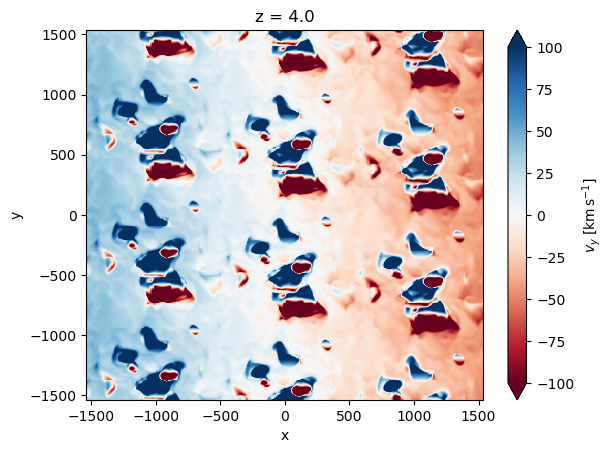

In [127]:
from pyathena.tigress_ncr.load_sim_tigress_ncr import LoadSimTIGRESSNCR
s = LoadSimTIGRESSNCR("/tigress/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.xy2048.eps0.0",verbose=True)
ds = s.load_vtk(290)
data = ds.get_field(["nH","T","vy"])
data_exp = expand_xy(s,data.sel(z=0,method="nearest")) # expanded 2D slices
data_exp["vy"].plot(**s.dfi["vy"]["imshow_args"])

In [114]:
# expand domain for the full 3D array
data_exp = expand_xy(s,data)

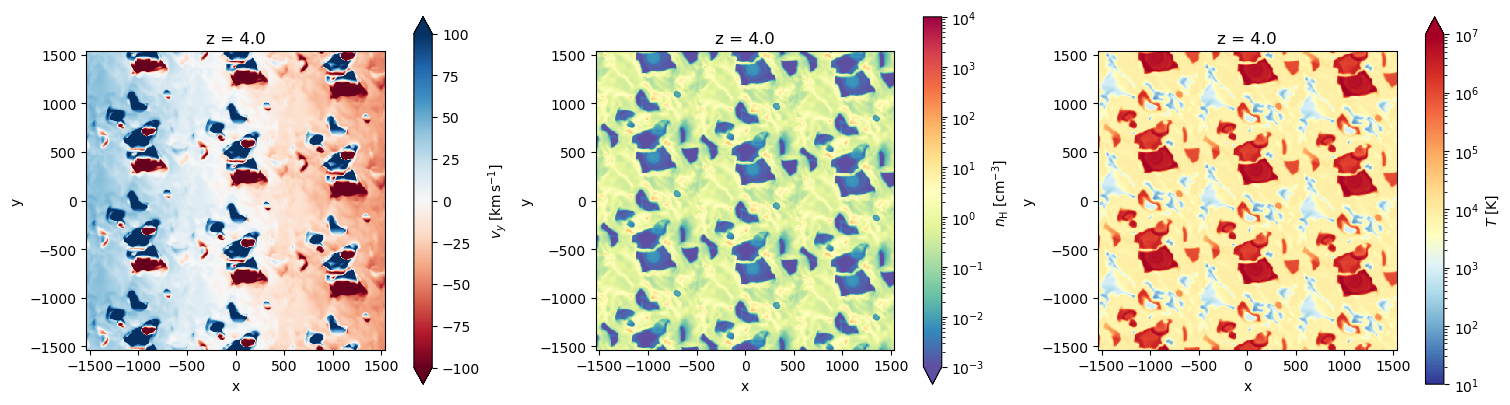

In [118]:
# slice later to show in the XY plane
fig, axes = plt.subplots(1,3, figsize=(15,4), constrained_layout=True)
for f, ax in zip(data_xexp, axes):
    data_exp[f].sel(z=0,method="nearest").plot(ax=ax,**s.dfi[f]["imshow_args"])
    ax.set_aspect("equal")

In [124]:
# slice first, and expand domain for the 2D array
data_exp = expand_xy(s,data.sel(z=0,method="nearest"))

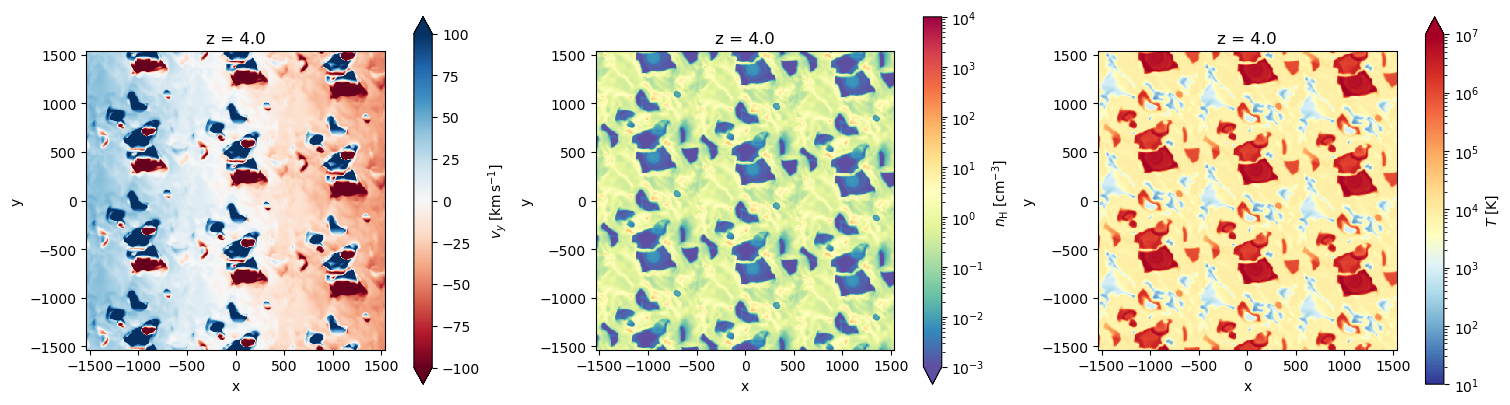

In [121]:
# show in the XY plane
fig, axes = plt.subplots(1,3, figsize=(15,4), constrained_layout=True)
for f, ax in zip(data_xexp, axes):
    data_exp[f].plot(ax=ax,**s.dfi[f]["imshow_args"])
    ax.set_aspect("equal")